## Import, Download, Read File

In [ ]:
import os
import sys

import pickle
import numpy as np
import scipy
import torch
# import sklearn
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import copy
import random
import gc
import math
from statsmodels.stats.weightstats import ztest
from scipy.stats import norm
from collections import defaultdict
from torch import nn

# NOTE: change this to fit your platform
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Harvard/6.8610_proj/data' # change to your own path!
df_major = pd.read_csv(os.path.join(path, 'cities.csv'), index_col=0)

In [ ]:
with open(os.path.join(path, 'acc_all.pkl'), 'rb') as f:
    acc_all = pickle.load(f)

In [ ]:
prompt_template = "{} is located in the country of"
df_major['prompt'] = df_major.admin_name.apply(lambda x: prompt_template.format(x))

In [ ]:
from transformers import GPT2Tokenizer, GPTNeoForCausalLM

tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'
tokenizer.truncation_side = 'left'

model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B").to(device)
model.requires_grad_(False)

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.31G [00:00<?, ?B/s]

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 2048)
    (wpe): Embedding(2048, 2048)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPTNeoBlock(
        (ln_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (out_proj): Linear(in_features=2048, out_features=2048, bias=True)
          )
        )
        (ln_2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=2048, out_features=8192, bias=True)
          (c_proj):

In [ ]:
df_major['country_token'] = df_major.country.apply(lambda x:tokenizer.encode(x)[0])

In [ ]:
# only need to run once!

ids, token, masks, hiddens_all = [], [], [], defaultdict(list)
# # df_major = df_major.drop_duplicates(['city','admin_name'])
bs = 1
with torch.no_grad():
  for i in tqdm(range(0, len(df_major) , bs)):
      end = min(len(df_major), i+bs)

      id = df_major.index.values[i:end]
      n = list(df_major.loc[id].prompt.values)
      # if type(adm) != float: n = ', '.join([n,adm])
    #   inputs = tokenizer(n, padding=True, return_tensors='pt').to(device)
      inputs = tokenizer(n, return_tensors='pt').to(device)
      ids.append(id)
      token.append(inputs.input_ids.cpu())
      masks.append(inputs.attention_mask.cpu())
      h=model(**inputs, output_hidden_states=True).hidden_states
      hiddens_all[6].append(h[6].cpu())
      hiddens_all[12].append(h[12].cpu())
      hiddens_all[18].append(h[18].cpu())
      hiddens_all[24].append(h[24].cpu())
      del inputs, h
#     j+=1
#     if j%1==0:print(j)
#     if i > 5:break

with open(os.path.join(path, 'hiddens_all.pkl'), 'wb') as f:
    pickle.dump(hiddens_all, f)

100%|██████████| 8540/8540 [06:21<00:00, 22.36it/s]


In [ ]:
with open(os.path.join(path, 'hiddens_all.pkl'), 'rb') as f:
    hiddens_all = pickle.load(f)

## Define Vars

In [ ]:
LAYER = 12
hiddens = hiddens_all[LAYER]
SEED = 27
LAST_ENTITY_TOKEN = -7

## Helper Functions

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

def load_data(d, bs=64, feat_name='hidden_state',seed=0):
  def compose_dataset(tokenizer, names, labels, coord):
      tokenize_res = tokenizer(list(names), truncation=True, max_length=8, padding=True, return_tensors='pt')
      input_ids, mask = tokenize_res.input_ids, tokenize_res.attention_mask
      ds = TensorDataset(input_ids, mask, torch.tensor(labels, dtype=torch.long), torch.tensor(coord, dtype=torch.float32))
      return ds

  def collate_fn(batch):
      ids, mask, label, coord= [],[],[],[]
      for s in batch:
          ids.append(s[0])
          mask.append(s[1])
          label.append(s[2])
          coord.append(s[3])
    #   inputs = {'input_ids':torch.stack(ids), 'mask':torch.stack(mask), 'label':torch.stack(label), 'coord':torch.stack(coord)}
      inputs = {'label':torch.stack(label), 'coord':torch.stack(coord)}
      return inputs

  def collate_fn_hiddens(batch):
      ids, mask, hidden, label, coord, cid = [],[],[],[],[],[]
      for s in batch:
          emb, token, m = d[s[0].item()]
        #   print(emb.shape)
          hidden.append(emb)
        #   ids.append(token)
          cid.append(s[0])
          mask.append(m)
          label.append(s[1])
          coord.append(s[2])
      inputs = {'cid': torch.stack(cid), feat_name:torch.stack(hidden) ,'label':torch.stack(label), 'coord':torch.stack(coord)}
      return inputs


  # names, label = df_major.city_ascii.values, df_major.loc[:,["country_id","lat",'lng']].values
  # xt, xv, yt, yv = train_test_split(names, label, test_size=0.2, random_state=0, stratify=label[:,0])
  # train_ds = compose_dataset(tokenizer, xt, yt[:,0], yt[:,1:])
  # val_ds = compose_dataset(tokenizer, xv, yv[:,0], yv[:,1:])
  # train_loader =  DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
  # val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)

  # Random
  names, label = df_major.index.values, df_major.loc[:,["country_id","lat",'lng']].values
#   xt, xv, yt, yv = train_test_split(names, label, test_size=0.2, random_state=seed)
  xt, xv, yt, yv = train_test_split(names, label, test_size=0.2, random_state=seed, stratify=label[:,0])

  # By country
  # c_out = ['China']
  # xt, xv = df_major[~df_major.country.isin(c_out)].index.values, df_major[df_major.country.isin(c_out)].index.values
  # yt, yv = df_major.loc[xt,["country_id","lat",'lng']].values, df_major.loc[xv,["country_id","lat",'lng']].values

  train_ds = TensorDataset(torch.tensor(xt, dtype=torch.long), torch.tensor(yt[:,0], dtype=torch.long), torch.tensor(yt[:,1:], dtype=torch.float32))
  val_ds = TensorDataset(torch.tensor(xv, dtype=torch.long), torch.tensor(yv[:,0], dtype=torch.long), torch.tensor(yv[:,1:], dtype=torch.float32))
  train_loader =  DataLoader(train_ds, batch_size=bs, shuffle=True, collate_fn=collate_fn_hiddens)
  val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False, collate_fn=collate_fn_hiddens)

  return train_loader, val_loader

In [ ]:
def get_prob_for_token(predictions, token):
    next_token_logits = predictions[0, -1, :]
    probs = torch.nn.functional.softmax(next_token_logits, dim=-1)
    return probs[token]

In [ ]:
def get_logit_for_token(predictions, token):
    next_token_logits = predictions[0, -1, :]
    return next_token_logits[token].item()

In [ ]:
def get_logit_for_token_all(hiddens, tokens, layer):
    lg = []
    # for idx in tqdm(range(len(hiddens))):
    for idx in range(len(hiddens)):
        logits = predict_from_middle_single(hiddens[idx].to(device), layer)
        l = get_logit_for_token(logits, tokens[idx])
        lg.append(l)
    return lg

In [ ]:
def predict_top_1(predictions):
    next_token_logits = predictions[0, -1, :]
    probs = torch.nn.functional.softmax(next_token_logits, dim=-1)
    top_k_weights, top_k_indices = torch.topk(probs, 1, sorted=True)
    predicted_token = tokenizer.decode(top_k_indices[0])
    return predicted_token.strip(), top_k_weights[0].item()

In [ ]:
# def predict_top_k(predictions, top_k):
#     next_token_logits = predictions[0, -1, :]
#     probs = torch.nn.functional.softmax(next_token_logits, dim=-1)
#     top_k_weights, top_k_indices = torch.topk(probs, top_k, sorted=True)

#     for i, pred_idx in enumerate(top_k_indices):
#         predicted_token = tokenizer.decode([pred_idx])
#         token_weight = top_k_weights[i]
#         print("'%s'"%predicted_token, " | weights:", round(float(token_weight),4))

In [ ]:
def predict_top_k(predictions, top_k):
    next_token_logits = predictions[0, -1, :]
    probs = torch.nn.functional.softmax(next_token_logits, dim=-1)
    top_k_weights, top_k_indices = torch.topk(probs, top_k, sorted=True)
    res = []
    for i, pred_idx in enumerate(top_k_indices):
        predicted_token = tokenizer.decode([pred_idx]).strip()
        res.append(predicted_token)
    return res

In [ ]:
def predict_from_middle_single(hidden_state, layer):
    for i in range(layer, 24):
        hidden_state = model.transformer.h[i](hidden_state)[0]
    if layer != 24:
        hidden_state = model.transformer.ln_f(hidden_state)
    prediction = model.lm_head(hidden_state)
    return prediction

In [ ]:
def predict_from_middle_all(hiddens, layer):
    res, lg = [], []
    # for idx in tqdm(range(len(hiddens))):
    for idx in range(len(hiddens)):
        logits = predict_from_middle_single(hiddens[idx].to(device), layer)
        p, l = predict_top_1(logits)
        res.append(p)
        lg.append(l)
    return res, lg

In [ ]:
def predict_from_middle_all_topk(hiddens, layer, k):
    res, lg = [], []
    # for idx in tqdm(range(len(hiddens))):
    for idx in range(len(hiddens)):
        logits = predict_from_middle_single(hiddens[idx].to(device), layer)
        topk = predict_top_k(logits, k)
        res.append(topk)
    return res

In [ ]:
def count_equal(a, b):
    cnt = sum(a[i] == b[i] for i in range(len(a)))
    pct = cnt / len(a)
    return cnt, pct

In [ ]:
def count_hit(a, b):
    cnt1 = sum(a[i] in b[i] for i in range(len(a)))
    pct1 = cnt1 / len(a)

    cnt2, pct2 = count_equal(a, [x[0] for x in b])
    return pct1, pct2

## Classes

In [ ]:
class Base(nn.Module):
    def __init__(self, device='cpu', *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.best_model = None
        self.device = device

    def forward(self):
        pass

    def compute_loss(self):
        pass

    def train_all(self, train_iter, val_iter, epochs=20, learning_rate=1e-3):
        # Use Adam to optimize the parameters
        optim = torch.optim.AdamW(self.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=epochs*2)
        best_val_loss = float('inf')
        # Run the optimization for multiple epochs
        for epoch in tqdm(range(epochs)):
            # Switch the module to training mode
            self.train()
            losses = []
            with tqdm(enumerate(train_iter), desc='train', position=0) as pbar:
                for i, batch in pbar:
                    optim.zero_grad()
                    loss = self.compute_loss(batch)
                    loss.backward()
                    # torch.nn.utils.clip_grad_value_(self.parameters(), 1.)
                    optim.step()
                    losses.append(loss.item())
                    pbar.set_postfix(epoch=epoch, iter=i, loss=sum(losses)/len(losses))


                # Evaluate and track improvements on the validation dataset
                val_loss = self.evaluate(val_iter)
                scheduler.step()
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    self.best_model = copy.deepcopy(self.state_dict())
                epoch_loss = sum(losses)/len(losses)
                print(f'[val] Epoch{epoch}, val_loss={val_loss}')
        return best_val_loss

    def evaluate(self, iterator):
        """Returns the model's loss on a given dataset `iterator`."""
        self.eval()   # switch the module to evaluation mode
        losses = []     # running total of example
        with torch.no_grad():
            for batch in iterator:
                loss = self.compute_loss(batch)
                losses.append(loss.item())
        self.train()
        return sum(losses) / len(losses)

In [ ]:
class Classifier(Base):
    def __init__(self, n_class, transformer=None, in_features=1536, hidden_dim=1024, n_layer=1, device='cpu', **kwargs) -> None:
        super().__init__(device=device, **kwargs)
        self.hidden_dim = hidden_dim
        self.n_class = n_class
        self.transformer = transformer
        if self.transformer:
            self.transformer.requires_grad_(False)

        layers, n_in, n_out = [], in_features, in_features
        for i in range(n_layer-1):
            layers.append(nn.Linear(n_in, hidden_dim))
            # layers.append(nn.ReLU())
            # layers.append(nn.BatchNorm1d(hidden_dim))
            if i > 1: layers.append(nn.Dropout(0.3))
            n_in, n_out = hidden_dim, hidden_dim
        layers.append(nn.Linear(n_out, n_class))
        self.linear = nn.Sequential(*layers)
        self.loss_fn = nn.CrossEntropyLoss()
        self.device = device
        self.to(device)

    def get_hidden_states(self, inputs):
        # DeBERTa
        # emb = self.transformer.get_submodule("embeddings")(inputs['input_ids'].to(self.device))
        # # mask = self.encoder.get_attention_mask(inputs['mask'].to(self.device))
        # # print(mask.dtype)
        # rel_pos = self.transformer.encoder.get_rel_pos(emb.to(self.device))
        # prev = inputs.get('hidden_state', emb)
        # out = self.transformer.encoder(prev.to(self.device), inputs['mask'].to(self.device), output_hidden_states=False, relative_pos=rel_pos)
        # h = out.last_hidden_state

        # GPT-Neo
        out = self.transformer(inputs_embeds=inputs['hidden_state'].to(self.device),
                               attention_mask=inputs['mask'].to(self.device),
                               use_cache=False, output_hidden_states=True)
        h = out.hidden_states[-1].detach()
        del out
        return h

    def forward(self, inputs):
        last_hidden_state = inputs.get("last_hidden_state", None)
        if last_hidden_state is None:
            self.eval()
            with torch.no_grad():
                last_hidden_state = self.get_hidden_states(inputs)
            self.train()
        x = (last_hidden_state.to(self.device) * inputs['mask'].unsqueeze(2).to(self.device)).sum(1)
        logit = self.linear(x)
        return logit

    def compute_loss(self, inputs):
        """forward pass and compute loss"""
        pred = self.forward(inputs)
        return self.loss_fn(pred.view(-1, self.n_class), inputs['label'].to(self.device))

    def predict(self, inputs):
        """predict on one minibatch"""
        self.eval()
        with torch.no_grad():
            logit = self.forward(inputs)
            return torch.argmax(logit, -1)

In [ ]:
class GeoDist(nn.Module):
    def forward(self, predicted, target,w=1000):
        """Calculate geographical distance given latitude and longitude by Haversine formula"""
        deg_pred = torch.deg2rad(predicted)
        deg_gt = torch.deg2rad(target)
        lat1, lon1, lat2, lon2 = deg_pred[:,0],deg_pred[:,1],deg_gt[:,0],deg_gt[:,1]

        # Haversine formula
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = (dlat / 2).sin() ** 2 + lat1.cos() * lat2.cos() * (dlon / 2).sin() ** 2
        c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))

        # Radius of the Earth in kilometers (mean value)
        # radius = 6371.0

        # Calculate the distance
        distance = w * c

        return distance.mean(0)


class Regressor(Base):
    def __init__(self, n_class=2, in_features=1536, hidden_dim=1024, n_layer=1,
                 device='cpu', **kwargs) -> None:
        super().__init__(device, **kwargs)
        self.hidden_dim = hidden_dim
        self.n_class = n_class
        layers, n_in, n_out = [], in_features, in_features
        for i in range(n_layer-1):
            layers.append(nn.Linear(n_in, hidden_dim))
            layers.append(nn.ReLU())
            # layers.append(nn.BatchNorm1d(hidden_dim))
            # layers.append(nn.Dropout(0.3))
            n_in, n_out = hidden_dim, hidden_dim
        layers.append(nn.Linear(n_out, n_class))
        self.linear = nn.Sequential(*layers)
        # self.loss_fn = GeoDist()
        self.loss_fn = nn.MSELoss()
        self.device = device
        self.to(device)

    # def forward(self, x, mask):
    #     x=x * torch.unsqueeze(mask, 2)
    #     return self.linear(x.sum(1))
    #     # return (180 + self.linear(x.sum(1))) % 360 - 180

    def forward(self, x):
        return self.linear(x)
        # return (180 + self.linear(x.sum(1))) % 360 - 180

    def compute_loss(self, inputs):
        k = 'hidden_state' if 'hidden_state' in inputs.keys() else 'last_hidden_state'
        pred = self.forward(inputs[k].to(self.device))

        return self.loss_fn(pred, inputs['coord'].to(self.device))

    def compute_grad(self, x, gt):
        pred = self.forward(x)
        loss = self.loss_fn(pred, gt)
        loss.backward()
        return loss

    def predict(self, inputs):
        """predict on one minibatch"""
        self.eval()
        with torch.no_grad():
            k = 'hidden_state' if 'hidden_state' in inputs.keys() else 'last_hidden_state'
            pred = self.forward(inputs[k].to(self.device))
            return pred

In [ ]:
class Perturber(nn.Module):
    def __init__(self, in_features=1536, reg=None, cls=None,
                 device='cpu', **kwargs) -> None:
        super().__init__(**kwargs)
        self.regressor = reg
        self.classifier = cls
        # self.classifier.requires_grad_(False)
        self.n_features = in_features
        self.perturbed_samples = None
        self.device = device
        self.to(device)

    def perturb(self, train_loader, val_loader, epochs=10, lr=0.1):
        self.eval()
        train_samples = list(train_loader)
        # random.shuffle(train_samples)
        reg_losses, cls_acc = [], []
        tk, t1 = self.evaluate(train_samples)
        print(f'[val] Before perturbation, val_acc={t1}, val_acc@k={tk}')
        cls_acc.append((t1, tk))
        for epoch in tqdm(range(epochs)):
            # Switch the module to training mode
            self.train()
            losses = []
            with tqdm(enumerate(train_samples), desc='train', position=0) as pbar:
                for i, batch in pbar:
                    k = 'hidden_state' if 'hidden_state' in batch.keys() else 'last_hidden_state'
                    x, gt = batch[k], batch['coord']
                    x = nn.Parameter(x.to(self.device))
                    loss = self.regressor.compute_grad(x, gt.to(self.device))
                    losses.append(loss.item())
                    x_grad = x.grad.detach().cpu()
                    # x_grad = x_grad.flip([0])
                    x_pert = x.data.cpu()
                    x_norm = torch.norm_except_dim(x_pert)
                    # x_pert = x_pert - x_grad*lr
                    x_pert = x_pert + x_grad*lr
                    batch[k]=x_pert / torch.norm_except_dim(x_pert) * x_norm
                    del x, gt

                    pbar.set_postfix(epoch=epoch, iter=i, loss=sum(losses)/len(losses))

                reg_losses.append(sum(losses)/len(losses))
                # Evaluate and track improvements on the validation dataset
                if epoch % 10==0:
                    tk, t1 = self.evaluate(train_samples)
                    print(f'[val] Epoch{epoch}, val_acc={t1}, val_acc@k={tk}')
                    cls_acc.append((t1, tk))
        # tk, t1 = self.evaluate(train_samples)
        # print(f'[val] After perturbation, val_acc={t1}, val_acc@k={tk}')
        # cls_acc.append((t1, tk))

        self.perturbed_samples = train_samples
        return reg_losses, cls_acc

    def perturb_sample(self, x, mask, tgt, epochs=10, lr=0.1):
        x = nn.Parameter(copy.deepcopy(x).to(self.device))
        opt = torch.optim.Adam([x], lr=lr)
        # best = None
        # best_loss = float('inf')
        for epoch in (range(epochs)):
            loss = self.regressor.compute_grad(x.to(self.device), mask.to(self.device), tgt.to(self.device))
            opt.step()
            opt.zero_grad()
            # x_grad=x.grad.detach() * torch.unsqueeze(mask.to(self.device),2)
            # x_pert = x.data
            # x_norm = torch.norm_except_dim(x_pert)
            # x_pert = x_pert - x_grad*lr
            # x.data = x_pert / torch.norm_except_dim(x_pert) * x_norm
            # x.zero_grad()
            l = loss.item()
            print(l)
            # if l < best_loss:
            #   best_loss = l
            #   if best = copy.deepcopy(x.data)
        return x.data.detach().cpu()


    def evaluate(self, samples):
        # corr, total = 0,0
        # for sample in samples:
        #     pred = self.classifier.predict(sample).cpu()
        #     corr += (pred == sample['label']).float().sum()
        #     total += pred.shape[0]
        # return corr / total
        # t1 = self.classifier.predict_all(samples)
        tk, t1 = self.classifier.predict_all_topk(samples)
        return tk, t1

In [ ]:
class LLMNextWordPredictor:
    def __init__(self, hiddens, label):
        self.hiddens = hiddens
        self.label = label

    def perturb(self, perturbed_samples):
        perturbed = [i.clone() for batch in perturbed_samples for i in batch['last_hidden_state']]
        for i in range(len(self.hiddens)):
            self.hiddens[i][:,LAST_ENTITY_TOKEN,:] = perturbed[i]

    def predict_all(self, perturbed_samples):
        self.perturb(perturbed_samples)
        res, probs = predict_from_middle_all(self.hiddens, LAYER)
        cnt, pct = count_equal(self.label, res)
        return pct

    def predict_all_topk(self, perturbed_samples):
        self.perturb(perturbed_samples)
        res = predict_from_middle_all_topk(self.hiddens, LAYER, 5)
        pct1, pct2 = count_hit(self.label, res)
        return pct1, pct2

## Process Data

### Common Process

In [ ]:
id = torch.load(os.path.join(path, 'full_cid.pt'))
tokens = torch.load(os.path.join(path, 'full_tokens.pt'))
masks = torch.load(os.path.join(path, 'full_masks.pt'))
d = {id[i].item():(hiddens[i][0][-7], tokens[i], masks[i]) for i in range(id.shape[0])}

In [ ]:
hiddens_dict = {id[i]:hiddens[i] for i in range(len(id))}

### Single Run

In [ ]:
train_loader, val_loader = load_data(d, 256, "last_hidden_state", seed=SEED)

In [ ]:
val_cid = [i.item() for batch in list(val_loader) for i in batch['cid']]

In [ ]:
val_cid[0]

1840058431

In [ ]:
val_label = [df_major.loc[cid]['country'] for cid in val_cid]
val_label_token = [df_major.loc[cid]['country_token'] for cid in val_cid]
val_pred = [df_major.loc[cid]['pred'].strip() for cid in val_cid]

In [ ]:
len(val_label_token)

1708

In [ ]:
count_equal(val_label, val_pred)

(849, 0.4970725995316159)

In [ ]:
val_hiddens_ori = [hiddens_dict[cid] for cid in val_cid]

In [ ]:
logit_before = get_logit_for_token_all(val_hiddens_ori, val_label_token, LAYER)

## Training

In [ ]:
reg = Regressor(in_features=2048, n_layer=1, hidden_dim=16, device=device)
reg.train_all(train_loader, val_loader, 50, 1e-3)

train: 27it [00:00, 40.98it/s, epoch=0, iter=26, loss=2.8e+3]
  2%|▏         | 1/50 [00:00<00:34,  1.42it/s]

[val] Epoch0, val_loss=2233.5919015066966


train: 27it [00:00, 127.89it/s, epoch=1, iter=26, loss=1.95e+3]
  4%|▍         | 2/50 [00:00<00:20,  2.29it/s]

[val] Epoch1, val_loss=1642.558803013393


train: 27it [00:00, 131.60it/s, epoch=2, iter=26, loss=1.51e+3]
  6%|▌         | 3/50 [00:01<00:16,  2.84it/s]

[val] Epoch2, val_loss=1319.080845424107


train: 27it [00:00, 122.35it/s, epoch=3, iter=26, loss=1.24e+3]
  8%|▊         | 4/50 [00:01<00:14,  3.16it/s]

[val] Epoch3, val_loss=1120.8417707170759


train: 27it [00:00, 126.03it/s, epoch=4, iter=26, loss=1.07e+3]
 10%|█         | 5/50 [00:01<00:13,  3.40it/s]

[val] Epoch4, val_loss=991.4323032924107


train: 27it [00:00, 131.32it/s, epoch=5, iter=26, loss=962]
 12%|█▏        | 6/50 [00:01<00:12,  3.62it/s]

[val] Epoch5, val_loss=902.9030412946429


train: 27it [00:00, 118.85it/s, epoch=6, iter=26, loss=874]
 14%|█▍        | 7/50 [00:02<00:11,  3.63it/s]

[val] Epoch6, val_loss=841.4838344029018


train: 27it [00:00, 128.38it/s, epoch=7, iter=26, loss=817]
 16%|█▌        | 8/50 [00:02<00:11,  3.73it/s]

[val] Epoch7, val_loss=790.811261858259


train: 27it [00:00, 123.93it/s, epoch=8, iter=26, loss=770]
 18%|█▊        | 9/50 [00:02<00:10,  3.78it/s]

[val] Epoch8, val_loss=753.8041730608259


train: 27it [00:00, 131.70it/s, epoch=9, iter=26, loss=729]
 20%|██        | 10/50 [00:02<00:10,  3.87it/s]

[val] Epoch9, val_loss=721.6360909598214


train: 27it [00:00, 115.34it/s, epoch=10, iter=26, loss=695]
 22%|██▏       | 11/50 [00:03<00:10,  3.80it/s]

[val] Epoch10, val_loss=696.9355032784598


train: 27it [00:00, 126.22it/s, epoch=11, iter=26, loss=668]
 24%|██▍       | 12/50 [00:03<00:09,  3.81it/s]

[val] Epoch11, val_loss=675.1421595982143


train: 27it [00:00, 132.20it/s, epoch=12, iter=26, loss=643]
 26%|██▌       | 13/50 [00:03<00:09,  3.90it/s]

[val] Epoch12, val_loss=653.3949584960938


train: 27it [00:00, 132.63it/s, epoch=13, iter=26, loss=623]
 28%|██▊       | 14/50 [00:04<00:09,  3.96it/s]

[val] Epoch13, val_loss=637.4982125418527


train: 27it [00:00, 127.09it/s, epoch=14, iter=26, loss=606]
 30%|███       | 15/50 [00:04<00:08,  3.95it/s]

[val] Epoch14, val_loss=625.2628784179688


train: 27it [00:00, 125.84it/s, epoch=15, iter=26, loss=586]
 32%|███▏      | 16/50 [00:04<00:08,  3.93it/s]

[val] Epoch15, val_loss=608.2272426060268


train: 27it [00:00, 121.97it/s, epoch=16, iter=26, loss=571]
 34%|███▍      | 17/50 [00:04<00:08,  3.90it/s]

[val] Epoch16, val_loss=595.1553824288504


train: 27it [00:00, 132.10it/s, epoch=17, iter=26, loss=557]
 36%|███▌      | 18/50 [00:05<00:08,  3.95it/s]

[val] Epoch17, val_loss=584.1424429757254


train: 27it [00:00, 133.61it/s, epoch=18, iter=26, loss=544]
 38%|███▊      | 19/50 [00:05<00:07,  4.00it/s]

[val] Epoch18, val_loss=574.0623517717634


train: 27it [00:00, 127.32it/s, epoch=19, iter=26, loss=532]
 40%|████      | 20/50 [00:05<00:07,  3.98it/s]

[val] Epoch19, val_loss=563.1847446986607


train: 27it [00:00, 66.68it/s, epoch=20, iter=26, loss=519]
 42%|████▏     | 21/50 [00:05<00:08,  3.23it/s]

[val] Epoch20, val_loss=556.2182094029018


train: 27it [00:00, 127.79it/s, epoch=21, iter=26, loss=510]
 44%|████▍     | 22/50 [00:06<00:08,  3.43it/s]

[val] Epoch21, val_loss=549.9696873256138


train: 27it [00:00, 129.36it/s, epoch=22, iter=26, loss=502]
 46%|████▌     | 23/50 [00:06<00:07,  3.58it/s]

[val] Epoch22, val_loss=541.8196149553571


train: 27it [00:00, 103.53it/s, epoch=23, iter=26, loss=492]
 48%|████▊     | 24/50 [00:06<00:07,  3.44it/s]

[val] Epoch23, val_loss=532.4396187918527


train: 27it [00:00, 95.13it/s, epoch=24, iter=26, loss=485]
 50%|█████     | 25/50 [00:07<00:07,  3.28it/s]

[val] Epoch24, val_loss=528.4571925571987


train: 27it [00:00, 93.38it/s, epoch=25, iter=26, loss=478]
 52%|█████▏    | 26/50 [00:07<00:07,  3.17it/s]

[val] Epoch25, val_loss=520.8285696847098


train: 27it [00:00, 103.34it/s, epoch=26, iter=26, loss=469]
 54%|█████▍    | 27/50 [00:07<00:07,  3.18it/s]

[val] Epoch26, val_loss=513.5875810895648


train: 27it [00:00, 97.85it/s, epoch=27, iter=26, loss=461] 
 56%|█████▌    | 28/50 [00:08<00:07,  3.13it/s]

[val] Epoch27, val_loss=508.730704171317


train: 27it [00:00, 104.73it/s, epoch=28, iter=26, loss=456]
 58%|█████▊    | 29/50 [00:08<00:06,  3.14it/s]

[val] Epoch28, val_loss=503.90354701450894


train: 27it [00:00, 96.42it/s, epoch=29, iter=26, loss=447] 
 60%|██████    | 30/50 [00:08<00:06,  3.09it/s]

[val] Epoch29, val_loss=499.24161638532365


train: 27it [00:00, 103.48it/s, epoch=30, iter=26, loss=443]
 62%|██████▏   | 31/50 [00:09<00:06,  3.12it/s]

[val] Epoch30, val_loss=495.98995099748885


train: 27it [00:00, 103.35it/s, epoch=31, iter=26, loss=439]
 64%|██████▍   | 32/50 [00:09<00:05,  3.14it/s]

[val] Epoch31, val_loss=491.334725516183


train: 27it [00:00, 100.82it/s, epoch=32, iter=26, loss=432]
 66%|██████▌   | 33/50 [00:09<00:05,  3.11it/s]

[val] Epoch32, val_loss=486.1450456891741


train: 27it [00:00, 107.21it/s, epoch=33, iter=26, loss=427]
 68%|██████▊   | 34/50 [00:10<00:05,  3.14it/s]

[val] Epoch33, val_loss=483.2560119628906


train: 27it [00:00, 103.68it/s, epoch=34, iter=26, loss=423]
 70%|███████   | 35/50 [00:10<00:04,  3.11it/s]

[val] Epoch34, val_loss=480.99087960379467


train: 27it [00:00, 91.51it/s, epoch=35, iter=26, loss=419]
 72%|███████▏  | 36/50 [00:10<00:04,  3.01it/s]

[val] Epoch35, val_loss=475.9598911830357


train: 27it [00:00, 99.72it/s, epoch=36, iter=26, loss=416]
 74%|███████▍  | 37/50 [00:11<00:04,  3.03it/s]

[val] Epoch36, val_loss=472.1098894391741


train: 27it [00:00, 114.54it/s, epoch=37, iter=26, loss=410]
 76%|███████▌  | 38/50 [00:11<00:03,  3.16it/s]

[val] Epoch37, val_loss=471.6491394042969


train: 27it [00:00, 115.00it/s, epoch=38, iter=26, loss=406]
 78%|███████▊  | 39/50 [00:11<00:03,  3.26it/s]

[val] Epoch38, val_loss=466.4817897251674


train: 27it [00:00, 95.21it/s, epoch=39, iter=26, loss=402]
 80%|████████  | 40/50 [00:11<00:03,  3.17it/s]

[val] Epoch39, val_loss=464.7238246372768


train: 27it [00:00, 97.82it/s, epoch=40, iter=26, loss=399]
 82%|████████▏ | 41/50 [00:12<00:02,  3.14it/s]

[val] Epoch40, val_loss=461.70494297572543


train: 27it [00:00, 108.80it/s, epoch=41, iter=26, loss=396]
 84%|████████▍ | 42/50 [00:12<00:02,  3.24it/s]

[val] Epoch41, val_loss=459.4285409109933


train: 27it [00:00, 129.47it/s, epoch=42, iter=26, loss=394]
 86%|████████▌ | 43/50 [00:12<00:02,  3.44it/s]

[val] Epoch42, val_loss=456.7744358607701


train: 27it [00:00, 133.83it/s, epoch=43, iter=26, loss=391]
 88%|████████▊ | 44/50 [00:13<00:01,  3.62it/s]

[val] Epoch43, val_loss=454.0363246372768


train: 27it [00:00, 127.50it/s, epoch=44, iter=26, loss=387]
 90%|█████████ | 45/50 [00:13<00:01,  3.71it/s]

[val] Epoch44, val_loss=452.1232430594308


train: 27it [00:00, 128.71it/s, epoch=45, iter=26, loss=385]
 92%|█████████▏| 46/50 [00:13<00:01,  3.79it/s]

[val] Epoch45, val_loss=449.99578857421875


train: 27it [00:00, 130.88it/s, epoch=46, iter=26, loss=381]
 94%|█████████▍| 47/50 [00:13<00:00,  3.87it/s]

[val] Epoch46, val_loss=448.33453369140625


train: 27it [00:00, 131.41it/s, epoch=47, iter=26, loss=381]
 96%|█████████▌| 48/50 [00:14<00:00,  3.91it/s]

[val] Epoch47, val_loss=446.51314435686385


train: 27it [00:00, 129.68it/s, epoch=48, iter=26, loss=378]
 98%|█████████▊| 49/50 [00:14<00:00,  3.94it/s]

[val] Epoch48, val_loss=444.6281171526228


train: 27it [00:00, 129.94it/s, epoch=49, iter=26, loss=375]
100%|██████████| 50/50 [00:14<00:00,  3.44it/s]

[val] Epoch49, val_loss=442.8844996861049


442.8844996861049

### gradient descent

In [ ]:
val_hiddens_pert = [hiddens_dict[cid].clone() for cid in val_cid]
cls = LLMNextWordPredictor(val_hiddens_pert, val_label)

In [ ]:
pert = Perturber(in_features=2048, reg=reg, cls=cls, device=device)
loss, acc = pert.perturb(val_loader, None, epochs=100,lr=1)

[val] Before perturbation, val_acc=0.4970725995316159, val_acc@k=0.7043325526932084


train: 7it [00:00, 47.48it/s, epoch=0, iter=6, loss=443]
  1%|          | 1/100 [00:42<1:10:13, 42.56s/it]

[val] Epoch0, val_acc=0.4970725995316159, val_acc@k=0.7049180327868853


train: 7it [00:00, 47.52it/s, epoch=1, iter=6, loss=267]
train: 7it [00:00, 55.09it/s, epoch=2, iter=6, loss=165]
train: 7it [00:00, 42.47it/s, epoch=3, iter=6, loss=105]
train: 7it [00:00, 51.87it/s, epoch=4, iter=6, loss=68.7]
train: 7it [00:00, 53.52it/s, epoch=5, iter=6, loss=46.5]
train: 7it [00:00, 38.18it/s, epoch=6, iter=6, loss=32.7]
train: 7it [00:00, 42.32it/s, epoch=7, iter=6, loss=23.8]
train: 7it [00:00, 55.78it/s, epoch=8, iter=6, loss=17.9]
train: 7it [00:00, 54.55it/s, epoch=9, iter=6, loss=13.9]
train: 7it [00:00, 52.57it/s, epoch=10, iter=6, loss=11.1]
 11%|█         | 11/100 [01:23<18:49, 12.69s/it]

[val] Epoch10, val_acc=0.49824355971896955, val_acc@k=0.7072599531615925


train: 7it [00:00, 122.35it/s, epoch=11, iter=6, loss=9.08]
train: 7it [00:00, 138.81it/s, epoch=12, iter=6, loss=7.54]
train: 7it [00:00, 139.34it/s, epoch=13, iter=6, loss=6.34]
train: 7it [00:00, 118.35it/s, epoch=14, iter=6, loss=5.39]
train: 7it [00:00, 139.23it/s, epoch=15, iter=6, loss=4.61]
train: 7it [00:00, 152.84it/s, epoch=16, iter=6, loss=3.97]
train: 7it [00:00, 150.40it/s, epoch=17, iter=6, loss=3.43]
train: 7it [00:00, 142.96it/s, epoch=18, iter=6, loss=2.97]
train: 7it [00:00, 143.91it/s, epoch=19, iter=6, loss=2.58]
train: 7it [00:00, 146.79it/s, epoch=20, iter=6, loss=2.24]
 21%|██        | 21/100 [02:20<13:35, 10.32s/it]

[val] Epoch20, val_acc=0.49824355971896955, val_acc@k=0.7078454332552693


train: 7it [00:00, 96.82it/s, epoch=21, iter=6, loss=1.95]
train: 7it [00:00, 97.66it/s, epoch=22, iter=6, loss=1.7]
train: 7it [00:00, 74.95it/s, epoch=23, iter=6, loss=1.48]
train: 7it [00:00, 75.52it/s, epoch=24, iter=6, loss=1.29]
train: 7it [00:00, 71.18it/s, epoch=25, iter=6, loss=1.12]
train: 7it [00:00, 125.31it/s, epoch=26, iter=6, loss=0.979]
train: 7it [00:00, 78.16it/s, epoch=27, iter=6, loss=0.854]
train: 7it [00:00, 141.43it/s, epoch=28, iter=6, loss=0.745]
train: 7it [00:00, 82.31it/s, epoch=29, iter=6, loss=0.65]
train: 7it [00:00, 113.73it/s, epoch=30, iter=6, loss=0.567]
 31%|███       | 31/100 [03:05<09:46,  8.51s/it]

[val] Epoch30, val_acc=0.49824355971896955, val_acc@k=0.7078454332552693


train: 7it [00:00, 151.09it/s, epoch=31, iter=6, loss=0.495]
train: 7it [00:00, 162.72it/s, epoch=32, iter=6, loss=0.432]
train: 7it [00:00, 178.34it/s, epoch=33, iter=6, loss=0.377]
train: 7it [00:00, 172.96it/s, epoch=34, iter=6, loss=0.329]
train: 7it [00:00, 177.25it/s, epoch=35, iter=6, loss=0.288]
train: 7it [00:00, 167.62it/s, epoch=36, iter=6, loss=0.251]
train: 7it [00:00, 170.24it/s, epoch=37, iter=6, loss=0.219]
train: 7it [00:00, 174.28it/s, epoch=38, iter=6, loss=0.192]
train: 7it [00:00, 161.05it/s, epoch=39, iter=6, loss=0.167]
train: 7it [00:00, 159.55it/s, epoch=40, iter=6, loss=0.146]
 41%|████      | 41/100 [03:44<06:33,  6.67s/it]

[val] Epoch40, val_acc=0.49882903981264637, val_acc@k=0.7078454332552693


train: 7it [00:00, 174.10it/s, epoch=41, iter=6, loss=0.128]
train: 7it [00:00, 163.77it/s, epoch=42, iter=6, loss=0.112]
train: 7it [00:00, 146.74it/s, epoch=43, iter=6, loss=0.0975]
train: 7it [00:00, 161.02it/s, epoch=44, iter=6, loss=0.0852]
train: 7it [00:00, 173.70it/s, epoch=45, iter=6, loss=0.0744]
train: 7it [00:00, 151.58it/s, epoch=46, iter=6, loss=0.065]
train: 7it [00:00, 165.07it/s, epoch=47, iter=6, loss=0.0568]
train: 7it [00:00, 158.45it/s, epoch=48, iter=6, loss=0.0496]
train: 7it [00:00, 151.80it/s, epoch=49, iter=6, loss=0.0434]
train: 7it [00:00, 155.09it/s, epoch=50, iter=6, loss=0.0379]
 51%|█████     | 51/100 [04:22<05:28,  6.71s/it]

[val] Epoch50, val_acc=0.49882903981264637, val_acc@k=0.7078454332552693


train: 7it [00:00, 133.45it/s, epoch=51, iter=6, loss=0.0331]
train: 7it [00:00, 149.22it/s, epoch=52, iter=6, loss=0.029]
train: 7it [00:00, 151.17it/s, epoch=53, iter=6, loss=0.0253]
train: 7it [00:00, 140.05it/s, epoch=54, iter=6, loss=0.0221]
train: 7it [00:00, 137.81it/s, epoch=55, iter=6, loss=0.0193]
train: 7it [00:00, 143.56it/s, epoch=56, iter=6, loss=0.0169]
train: 7it [00:00, 156.49it/s, epoch=57, iter=6, loss=0.0148]
train: 7it [00:00, 152.91it/s, epoch=58, iter=6, loss=0.0129]
train: 7it [00:00, 134.09it/s, epoch=59, iter=6, loss=0.0113]
train: 7it [00:00, 148.53it/s, epoch=60, iter=6, loss=0.00986]
 61%|██████    | 61/100 [05:00<04:23,  6.76s/it]

[val] Epoch60, val_acc=0.49882903981264637, val_acc@k=0.7078454332552693


train: 7it [00:00, 155.42it/s, epoch=61, iter=6, loss=0.00862]
train: 7it [00:00, 164.47it/s, epoch=62, iter=6, loss=0.00753]
train: 7it [00:00, 164.60it/s, epoch=63, iter=6, loss=0.00658]
train: 7it [00:00, 155.06it/s, epoch=64, iter=6, loss=0.00576]
train: 7it [00:00, 159.40it/s, epoch=65, iter=6, loss=0.00503]
train: 7it [00:00, 158.70it/s, epoch=66, iter=6, loss=0.0044]
train: 7it [00:00, 138.95it/s, epoch=67, iter=6, loss=0.00384]
train: 7it [00:00, 147.51it/s, epoch=68, iter=6, loss=0.00336]
train: 7it [00:00, 157.75it/s, epoch=69, iter=6, loss=0.00294]
train: 7it [00:00, 158.99it/s, epoch=70, iter=6, loss=0.00257]
 71%|███████   | 71/100 [05:40<03:46,  7.81s/it]

[val] Epoch70, val_acc=0.49882903981264637, val_acc@k=0.7078454332552693


train: 7it [00:00, 148.20it/s, epoch=71, iter=6, loss=0.00225]
train: 7it [00:00, 161.03it/s, epoch=72, iter=6, loss=0.00196]
train: 7it [00:00, 157.69it/s, epoch=73, iter=6, loss=0.00172]
train: 7it [00:00, 164.21it/s, epoch=74, iter=6, loss=0.0015]
train: 7it [00:00, 155.94it/s, epoch=75, iter=6, loss=0.00131]
train: 7it [00:00, 147.38it/s, epoch=76, iter=6, loss=0.00115]
train: 7it [00:00, 136.37it/s, epoch=77, iter=6, loss=0.001]
train: 7it [00:00, 162.94it/s, epoch=78, iter=6, loss=0.000876]
train: 7it [00:00, 127.41it/s, epoch=79, iter=6, loss=0.000766]
train: 7it [00:00, 162.63it/s, epoch=80, iter=6, loss=0.00067]
 81%|████████  | 81/100 [06:18<02:26,  7.73s/it]

[val] Epoch80, val_acc=0.49882903981264637, val_acc@k=0.7078454332552693


train: 7it [00:00, 132.30it/s, epoch=81, iter=6, loss=0.000585]
train: 7it [00:00, 118.73it/s, epoch=82, iter=6, loss=0.000512]
train: 7it [00:00, 143.01it/s, epoch=83, iter=6, loss=0.000447]
train: 7it [00:00, 129.05it/s, epoch=84, iter=6, loss=0.000391]
train: 7it [00:00, 164.09it/s, epoch=85, iter=6, loss=0.000342]
train: 7it [00:00, 160.04it/s, epoch=86, iter=6, loss=0.000299]
train: 7it [00:00, 170.09it/s, epoch=87, iter=6, loss=0.000261]
train: 7it [00:00, 175.24it/s, epoch=88, iter=6, loss=0.000228]
train: 7it [00:00, 162.79it/s, epoch=89, iter=6, loss=0.0002]
train: 7it [00:00, 158.80it/s, epoch=90, iter=6, loss=0.000175]
 91%|█████████ | 91/100 [06:55<00:53,  5.93s/it]

[val] Epoch90, val_acc=0.49882903981264637, val_acc@k=0.7078454332552693


train: 7it [00:00, 143.79it/s, epoch=91, iter=6, loss=0.000153]
train: 7it [00:00, 146.63it/s, epoch=92, iter=6, loss=0.000133]
train: 7it [00:00, 153.55it/s, epoch=93, iter=6, loss=0.000117]
train: 7it [00:00, 144.22it/s, epoch=94, iter=6, loss=0.000102]
train: 7it [00:00, 140.63it/s, epoch=95, iter=6, loss=8.92e-5]
train: 7it [00:00, 155.98it/s, epoch=96, iter=6, loss=7.8e-5]
train: 7it [00:00, 139.84it/s, epoch=97, iter=6, loss=6.82e-5]
train: 7it [00:00, 137.15it/s, epoch=98, iter=6, loss=5.96e-5]
train: 7it [00:00, 147.84it/s, epoch=99, iter=6, loss=5.21e-5]
100%|██████████| 100/100 [06:56<00:00,  4.16s/it]


In [ ]:
val_hiddens_pert[0][:,-7,:]

tensor([[-0.3277,  0.4885,  0.6551,  ..., -2.3343, -0.9234,  2.5668]])

In [ ]:
pert.perturbed_samples[0]['last_hidden_state']

tensor([[-3.2769e-01,  4.8849e-01,  6.5508e-01,  ..., -2.3343e+00,
         -9.2339e-01,  2.5668e+00],
        [ 3.3938e+00, -1.4823e+00,  4.8280e-01,  ..., -9.3201e-01,
         -8.7610e+00,  1.5523e+00],
        [-1.4665e+00, -8.7038e-01, -6.0473e-01,  ..., -5.0341e+00,
          3.4293e-01, -2.2034e+00],
        ...,
        [ 5.1342e-01, -1.8863e+00, -1.3976e+00,  ...,  2.1492e+00,
         -4.7923e-01, -2.9965e-01],
        [-5.0015e+00, -1.1155e+00,  1.0570e+00,  ...,  2.1057e+00,
          8.9597e-01,  6.2441e-01],
        [-1.5463e+00, -2.9865e+00, -3.0418e+00,  ..., -2.0230e+00,
         -1.8979e-01,  1.2607e-03]])

#### logit change

In [ ]:
logit_after = get_logit_for_token_all(val_hiddens_pert, val_label_token, LAYER)

In [ ]:
dlogit_gd = [logit_after[i]-logit_before[i] for i in range(len(logit_after))]

In [ ]:
with open(os.path.join(path, 'dlogit_gd.pkl'), 'wb') as f:
    pickle.dump(dlogit_gd, f)

In [ ]:
mu, std = norm.fit(dlogit_gd)
mu, std

(0.011838936589361634, 0.09229068966544757)

In [ ]:
p_gd = ztest(dlogit_gd)[1]

In [ ]:
p_gd

1.1583601544847669e-07

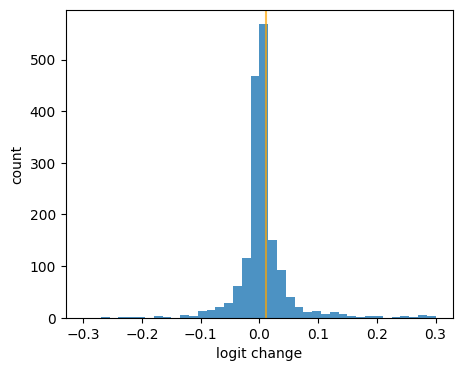

In [ ]:
plt.figure(figsize=(5,4))
plt.hist(dlogit_gd, 40, alpha=0.8, range=(-0.3, 0.3))
plt.axvline(sum(dlogit_gd)/len(dlogit_gd), alpha=0.7, color='orange')
plt.xlabel('logit change')
plt.ylabel('count')
# plt.title(f"logit change - gradient descent, mu = {sum(dlogit_gd)/len(dlogit_gd):.3f}")
plt.show()

### gradient ascent

In [ ]:
val_hiddens_pert = [hiddens_dict[cid].clone() for cid in val_cid]
cls = LLMNextWordPredictor(val_hiddens_pert, val_label)
pert2 = Perturber(in_features=2048, reg=reg, cls=cls, device=device)
loss2, acc2 = pert2.perturb(val_loader, None, epochs=100,lr=1)

[val] Before perturbation, val_acc=0.4970725995316159, val_acc@k=0.7043325526932084


train: 7it [00:00, 98.67it/s, epoch=0, iter=6, loss=443]
  1%|          | 1/100 [00:39<1:05:44, 39.84s/it]

[val] Epoch0, val_acc=0.4964871194379391, val_acc@k=0.7037470725995316


train: 7it [00:00, 121.26it/s, epoch=1, iter=6, loss=667]
train: 7it [00:00, 159.89it/s, epoch=2, iter=6, loss=1.02e+3]
train: 7it [00:00, 164.72it/s, epoch=3, iter=6, loss=1.56e+3]
train: 7it [00:00, 143.93it/s, epoch=4, iter=6, loss=2.41e+3]
train: 7it [00:00, 139.47it/s, epoch=5, iter=6, loss=3.76e+3]
train: 7it [00:00, 140.83it/s, epoch=6, iter=6, loss=5.9e+3]
train: 7it [00:00, 127.27it/s, epoch=7, iter=6, loss=9.34e+3]
train: 7it [00:00, 158.05it/s, epoch=8, iter=6, loss=1.49e+4]
train: 7it [00:00, 154.79it/s, epoch=9, iter=6, loss=2.38e+4]
train: 7it [00:00, 136.57it/s, epoch=10, iter=6, loss=3.83e+4]
 11%|█         | 11/100 [01:18<11:46,  7.94s/it]

[val] Epoch10, val_acc=0.4642857142857143, val_acc@k=0.65807962529274


train: 7it [00:00, 150.18it/s, epoch=11, iter=6, loss=6.14e+4]
train: 7it [00:00, 154.29it/s, epoch=12, iter=6, loss=9.8e+4]
train: 7it [00:00, 149.16it/s, epoch=13, iter=6, loss=1.54e+5]
train: 7it [00:00, 158.67it/s, epoch=14, iter=6, loss=2.39e+5]
train: 7it [00:00, 152.97it/s, epoch=15, iter=6, loss=3.6e+5]
train: 7it [00:00, 145.20it/s, epoch=16, iter=6, loss=5.29e+5]
train: 7it [00:00, 146.74it/s, epoch=17, iter=6, loss=7.58e+5]
train: 7it [00:00, 160.97it/s, epoch=18, iter=6, loss=1.06e+6]
train: 7it [00:00, 147.34it/s, epoch=19, iter=6, loss=1.45e+6]
train: 7it [00:00, 153.61it/s, epoch=20, iter=6, loss=1.92e+6]
 21%|██        | 21/100 [01:57<09:15,  7.03s/it]

[val] Epoch20, val_acc=0.38583138173302106, val_acc@k=0.5673302107728337


train: 7it [00:00, 152.33it/s, epoch=21, iter=6, loss=2.49e+6]
train: 7it [00:00, 160.00it/s, epoch=22, iter=6, loss=3.16e+6]
train: 7it [00:00, 157.29it/s, epoch=23, iter=6, loss=3.91e+6]
train: 7it [00:00, 160.40it/s, epoch=24, iter=6, loss=4.75e+6]
train: 7it [00:00, 156.72it/s, epoch=25, iter=6, loss=5.67e+6]
train: 7it [00:00, 163.72it/s, epoch=26, iter=6, loss=6.65e+6]
train: 7it [00:00, 164.26it/s, epoch=27, iter=6, loss=7.7e+6]
train: 7it [00:00, 168.93it/s, epoch=28, iter=6, loss=8.81e+6]
train: 7it [00:00, 167.82it/s, epoch=29, iter=6, loss=9.95e+6]
train: 7it [00:00, 157.25it/s, epoch=30, iter=6, loss=1.11e+7]
 31%|███       | 31/100 [02:35<06:43,  5.85s/it]

[val] Epoch30, val_acc=0.21428571428571427, val_acc@k=0.3395784543325527


train: 7it [00:00, 144.28it/s, epoch=31, iter=6, loss=1.23e+7]
train: 7it [00:00, 140.63it/s, epoch=32, iter=6, loss=1.35e+7]
train: 7it [00:00, 153.84it/s, epoch=33, iter=6, loss=1.46e+7]
train: 7it [00:00, 132.50it/s, epoch=34, iter=6, loss=1.57e+7]
train: 7it [00:00, 151.48it/s, epoch=35, iter=6, loss=1.67e+7]
train: 7it [00:00, 123.42it/s, epoch=36, iter=6, loss=1.76e+7]
train: 7it [00:00, 121.03it/s, epoch=37, iter=6, loss=1.84e+7]
train: 7it [00:00, 122.68it/s, epoch=38, iter=6, loss=1.92e+7]
train: 7it [00:00, 131.47it/s, epoch=39, iter=6, loss=1.98e+7]
train: 7it [00:00, 131.84it/s, epoch=40, iter=6, loss=2.04e+7]
 41%|████      | 41/100 [03:13<06:35,  6.71s/it]

[val] Epoch40, val_acc=0.038056206088992975, val_acc@k=0.06381733021077284


train: 7it [00:00, 155.45it/s, epoch=41, iter=6, loss=2.09e+7]
train: 7it [00:00, 145.36it/s, epoch=42, iter=6, loss=2.13e+7]
train: 7it [00:00, 157.52it/s, epoch=43, iter=6, loss=2.17e+7]
train: 7it [00:00, 150.11it/s, epoch=44, iter=6, loss=2.2e+7]
train: 7it [00:00, 157.32it/s, epoch=45, iter=6, loss=2.22e+7]
train: 7it [00:00, 139.41it/s, epoch=46, iter=6, loss=2.25e+7]
train: 7it [00:00, 161.42it/s, epoch=47, iter=6, loss=2.27e+7]
train: 7it [00:00, 170.91it/s, epoch=48, iter=6, loss=2.28e+7]
train: 7it [00:00, 152.77it/s, epoch=49, iter=6, loss=2.29e+7]
train: 7it [00:00, 159.95it/s, epoch=50, iter=6, loss=2.31e+7]
 51%|█████     | 51/100 [03:51<05:48,  7.12s/it]

[val] Epoch50, val_acc=0.00819672131147541, val_acc@k=0.01522248243559719


train: 7it [00:00, 144.21it/s, epoch=51, iter=6, loss=2.32e+7]
train: 7it [00:00, 152.58it/s, epoch=52, iter=6, loss=2.32e+7]
train: 7it [00:00, 168.57it/s, epoch=53, iter=6, loss=2.33e+7]
train: 7it [00:00, 157.79it/s, epoch=54, iter=6, loss=2.34e+7]
train: 7it [00:00, 140.38it/s, epoch=55, iter=6, loss=2.34e+7]
train: 7it [00:00, 159.52it/s, epoch=56, iter=6, loss=2.34e+7]
train: 7it [00:00, 161.29it/s, epoch=57, iter=6, loss=2.35e+7]
train: 7it [00:00, 161.16it/s, epoch=58, iter=6, loss=2.35e+7]
train: 7it [00:00, 146.37it/s, epoch=59, iter=6, loss=2.35e+7]
train: 7it [00:00, 135.51it/s, epoch=60, iter=6, loss=2.35e+7]
 61%|██████    | 61/100 [04:29<04:03,  6.24s/it]

[val] Epoch60, val_acc=0.00351288056206089, val_acc@k=0.008782201405152224


train: 7it [00:00, 99.83it/s, epoch=61, iter=6, loss=2.35e+7]
train: 7it [00:00, 136.02it/s, epoch=62, iter=6, loss=2.35e+7]
train: 7it [00:00, 149.62it/s, epoch=63, iter=6, loss=2.36e+7]
train: 7it [00:00, 147.19it/s, epoch=64, iter=6, loss=2.36e+7]
train: 7it [00:00, 146.49it/s, epoch=65, iter=6, loss=2.36e+7]
train: 7it [00:00, 154.67it/s, epoch=66, iter=6, loss=2.36e+7]
train: 7it [00:00, 131.72it/s, epoch=67, iter=6, loss=2.36e+7]
train: 7it [00:00, 151.43it/s, epoch=68, iter=6, loss=2.36e+7]
train: 7it [00:00, 158.66it/s, epoch=69, iter=6, loss=2.36e+7]
train: 7it [00:00, 123.39it/s, epoch=70, iter=6, loss=2.36e+7]
 71%|███████   | 71/100 [05:07<03:14,  6.71s/it]

[val] Epoch70, val_acc=0.00117096018735363, val_acc@k=0.00585480093676815


train: 7it [00:00, 152.57it/s, epoch=71, iter=6, loss=2.36e+7]
train: 7it [00:00, 155.47it/s, epoch=72, iter=6, loss=2.36e+7]
train: 7it [00:00, 149.30it/s, epoch=73, iter=6, loss=2.36e+7]
train: 7it [00:00, 151.73it/s, epoch=74, iter=6, loss=2.36e+7]
train: 7it [00:00, 164.63it/s, epoch=75, iter=6, loss=2.36e+7]
train: 7it [00:00, 151.36it/s, epoch=76, iter=6, loss=2.36e+7]
train: 7it [00:00, 153.05it/s, epoch=77, iter=6, loss=2.36e+7]
train: 7it [00:00, 161.73it/s, epoch=78, iter=6, loss=2.36e+7]
train: 7it [00:00, 160.72it/s, epoch=79, iter=6, loss=2.36e+7]
train: 7it [00:00, 162.36it/s, epoch=80, iter=6, loss=2.36e+7]
 81%|████████  | 81/100 [05:45<02:09,  6.81s/it]

[val] Epoch80, val_acc=0.00117096018735363, val_acc@k=0.00585480093676815


train: 7it [00:00, 154.63it/s, epoch=81, iter=6, loss=2.36e+7]
train: 7it [00:00, 152.00it/s, epoch=82, iter=6, loss=2.36e+7]
train: 7it [00:00, 158.00it/s, epoch=83, iter=6, loss=2.36e+7]
train: 7it [00:00, 161.99it/s, epoch=84, iter=6, loss=2.36e+7]
train: 7it [00:00, 149.71it/s, epoch=85, iter=6, loss=2.36e+7]
train: 7it [00:00, 164.05it/s, epoch=86, iter=6, loss=2.36e+7]
train: 7it [00:00, 131.38it/s, epoch=87, iter=6, loss=2.36e+7]
train: 7it [00:00, 156.65it/s, epoch=88, iter=6, loss=2.36e+7]
train: 7it [00:00, 160.58it/s, epoch=89, iter=6, loss=2.36e+7]
train: 7it [00:00, 165.85it/s, epoch=90, iter=6, loss=2.36e+7]
 91%|█████████ | 91/100 [06:23<00:52,  5.81s/it]

[val] Epoch90, val_acc=0.00117096018735363, val_acc@k=0.00585480093676815


train: 7it [00:00, 144.69it/s, epoch=91, iter=6, loss=2.36e+7]
train: 7it [00:00, 144.44it/s, epoch=92, iter=6, loss=2.36e+7]
train: 7it [00:00, 154.73it/s, epoch=93, iter=6, loss=2.36e+7]
train: 7it [00:00, 129.69it/s, epoch=94, iter=6, loss=2.36e+7]
train: 7it [00:00, 137.63it/s, epoch=95, iter=6, loss=2.36e+7]
train: 7it [00:00, 140.17it/s, epoch=96, iter=6, loss=2.36e+7]
train: 7it [00:00, 153.07it/s, epoch=97, iter=6, loss=2.36e+7]
train: 7it [00:00, 156.43it/s, epoch=98, iter=6, loss=2.36e+7]
train: 7it [00:00, 148.75it/s, epoch=99, iter=6, loss=2.36e+7]
100%|██████████| 100/100 [06:24<00:00,  3.84s/it]


In [ ]:
acc2

[(0.4970725995316159, 0.7043325526932084),
 (0.4964871194379391, 0.7037470725995316),
 (0.4642857142857143, 0.65807962529274),
 (0.38583138173302106, 0.5673302107728337),
 (0.21428571428571427, 0.3395784543325527),
 (0.038056206088992975, 0.06381733021077284),
 (0.00819672131147541, 0.01522248243559719),
 (0.00351288056206089, 0.008782201405152224),
 (0.00117096018735363, 0.00585480093676815),
 (0.00117096018735363, 0.00585480093676815),
 (0.00117096018735363, 0.00585480093676815)]

In [ ]:
acc

[(0.4970725995316159, 0.7043325526932084),
 (0.4970725995316159, 0.7049180327868853),
 (0.49824355971896955, 0.7072599531615925),
 (0.49824355971896955, 0.7078454332552693),
 (0.49824355971896955, 0.7078454332552693),
 (0.49882903981264637, 0.7078454332552693),
 (0.49882903981264637, 0.7078454332552693),
 (0.49882903981264637, 0.7078454332552693),
 (0.49882903981264637, 0.7078454332552693),
 (0.49882903981264637, 0.7078454332552693),
 (0.49882903981264637, 0.7078454332552693)]

#### logit change

In [ ]:
logit_after = get_logit_for_token_all(val_hiddens_pert, val_label_token, LAYER)

In [ ]:
dlogit_ga = [logit_after[i]-logit_before[i] for i in range(len(logit_after))]

In [ ]:
with open(os.path.join(path, 'dlogit_ga.pkl'), 'wb') as f:
    pickle.dump(dlogit_ga, f)

In [ ]:
mu, std = norm.fit(dlogit_ga)
mu, std

(-9.258825873916825, 4.192015952159255)

In [ ]:
p_ga = ztest(dlogit_ga)[1]
p_ga

0.0

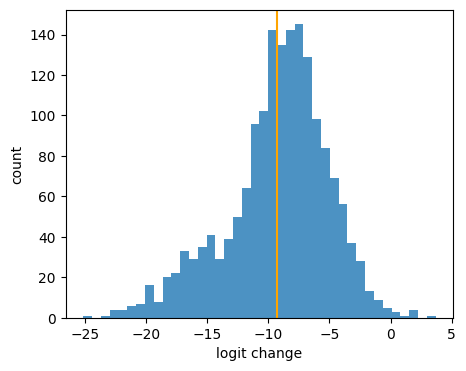

In [ ]:
plt.figure(figsize=(5,4))
plt.hist(dlogit_ga, 40, alpha=0.8)
plt.axvline(sum(dlogit_ga)/len(dlogit_ga), color='orange')
plt.xlabel('logit change')
plt.ylabel('count')
# plt.title(f"logit change - gradient ascent, mu = {sum(dlogit_ga)/len(dlogit_ga):.3f}")
plt.show()

### random perturbation

In [ ]:
# val_hiddens_pert = [hiddens_dict[cid].clone() for cid in val_cid]
# cls = LLMNextWordPredictor(val_hiddens_pert, val_label)
pert3 = Perturber(in_features=2048, reg=reg, cls=cls, device=device)
loss3, acc3 = pert3.perturb(val_loader, None, epochs=100,lr=1)

[val] Before perturbation, val_acc=0.4970725995316159, val_acc@k=0.7043325526932084


train: 7it [00:00, 80.72it/s, epoch=0, iter=6, loss=443]
train: 7it [00:00, 141.36it/s, epoch=1, iter=6, loss=468]
train: 7it [00:00, 166.34it/s, epoch=2, iter=6, loss=594]
train: 7it [00:00, 146.08it/s, epoch=3, iter=6, loss=842]
train: 7it [00:00, 153.70it/s, epoch=4, iter=6, loss=1.26e+3]
train: 7it [00:00, 149.52it/s, epoch=5, iter=6, loss=1.95e+3]
train: 7it [00:00, 142.33it/s, epoch=6, iter=6, loss=3.06e+3]
train: 7it [00:00, 141.92it/s, epoch=7, iter=6, loss=4.86e+3]
train: 7it [00:00, 141.53it/s, epoch=8, iter=6, loss=7.79e+3]
train: 7it [00:00, 133.41it/s, epoch=9, iter=6, loss=1.26e+4]
train: 7it [00:00, 128.66it/s, epoch=10, iter=6, loss=2.05e+4]
train: 7it [00:00, 127.86it/s, epoch=11, iter=6, loss=3.35e+4]
train: 7it [00:00, 148.74it/s, epoch=12, iter=6, loss=5.49e+4]
train: 7it [00:00, 162.42it/s, epoch=13, iter=6, loss=9e+4]
train: 7it [00:00, 138.34it/s, epoch=14, iter=6, loss=1.46e+5]
train: 7it [00:00, 145.37it/s, epoch=15, iter=6, loss=2.34e+5]
train: 7it [00:00, 127

[val] After perturbation, val_acc=0.0, val_acc@k=0.002927400468384075


In [ ]:
acc3

[(0.4970725995316159, 0.7043325526932084), (0.0, 0.002927400468384075)]

#### logit change

In [ ]:
logit_after = get_logit_for_token_all(val_hiddens_pert, val_label_token, LAYER)

In [ ]:
dlogit_random = [logit_after[i]-logit_before[i] for i in range(len(logit_after))]

In [ ]:
sum(dlogit_random)/len(dlogit_random)

-10.204500556027023

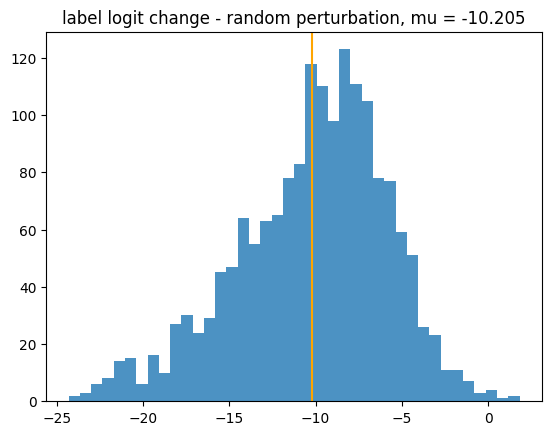

In [ ]:
plt.hist(dlogit_random, 40, alpha=0.8)
plt.axvline(sum(dlogit_random)/len(dlogit_random), color='orange')
plt.title(f"label logit change - random perturbation, mu = {sum(dlogit_random)/len(dlogit_random):.3f}")
plt.show()

#### accuracy change

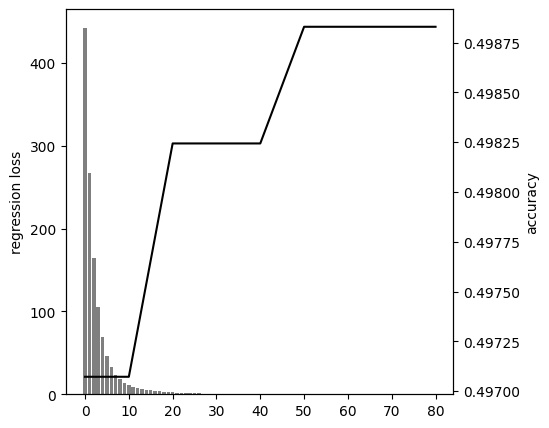

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax2 = ax.twinx()
ax.bar(range(0, 80), loss[:80], alpha=0.5, color='black')
ax.set_ylabel('regression loss')
ax2.plot(range(0, 81, 10), [e[0] for e in acc[:9]], color='black')
ax2.set_ylabel('accuracy')
plt.show()

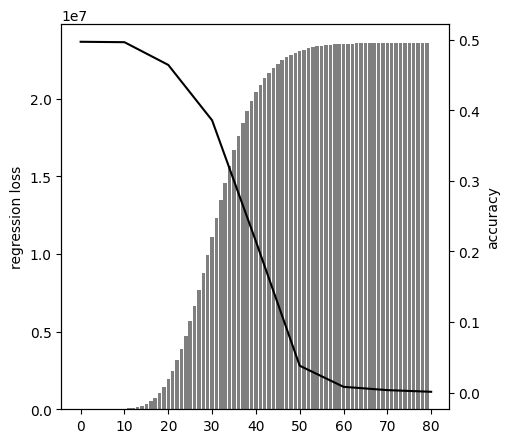

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax2 = ax.twinx()
ax.bar(range(0, 80), loss2[:80], alpha=0.5, color='black')
ax.set_ylabel('regression loss')
ax2.plot(range(0, 81, 10), [e[0] for e in acc2[:9]], color='black')
ax2.set_ylabel('accuracy')
plt.show()

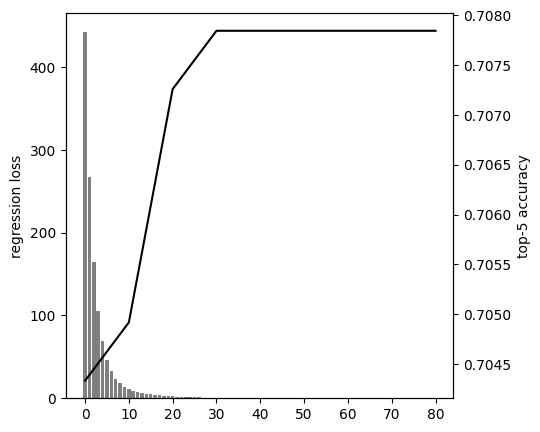

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax2 = ax.twinx()
ax.bar(range(0, 80), loss[:80], alpha=0.5, color='black')
ax.set_ylabel('regression loss')
ax2.plot(range(0, 81, 10), [e[1] for e in acc[:9]], color='black')
ax2.set_ylabel('top-5 accuracy')
plt.show()

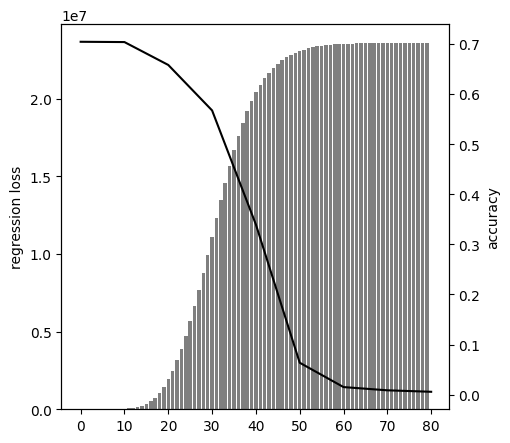

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax2 = ax.twinx()
ax.bar(range(0, 80), loss2[:80], alpha=0.5, color='black')
ax.set_ylabel('regression loss')
ax2.plot(range(0, 81, 10), [e[1] for e in acc2[:9]], color='black')
ax2.set_ylabel('accuracy')
plt.show()

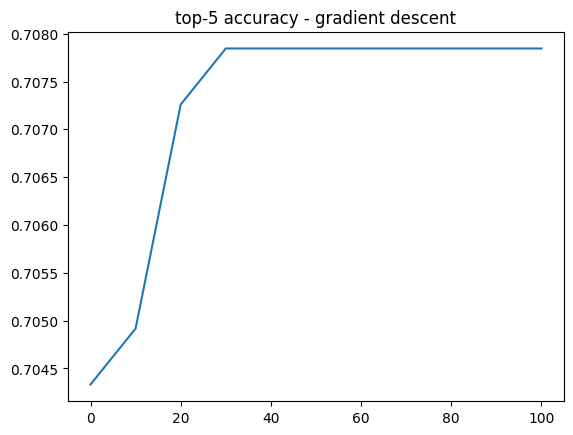

In [ ]:
plt.plot(range(0, 101, 10), [e[1] for e in acc])

plt.title('top-5 accuracy - gradient descent')
plt.show()

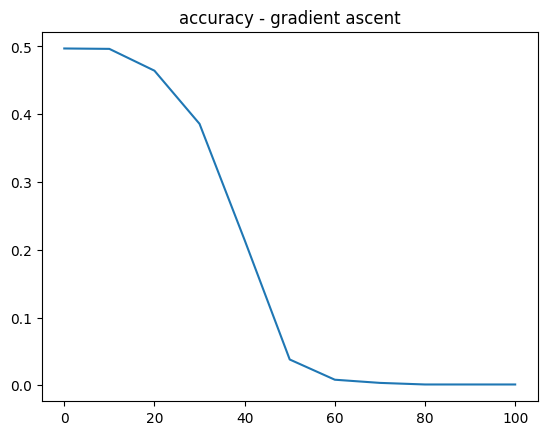

In [ ]:
plt.plot(range(0, 101, 10), [e[0] for e in acc2])

plt.title('accuracy - gradient ascent')
plt.show()

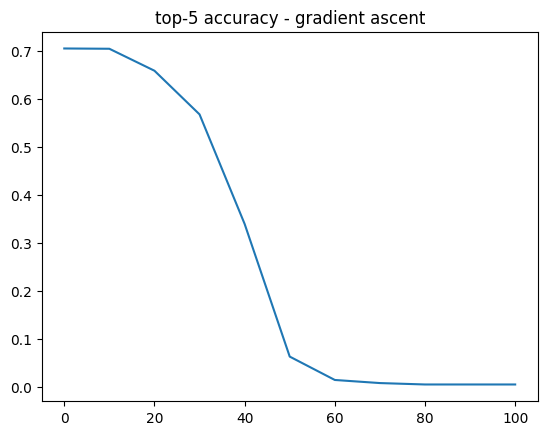

In [ ]:
plt.plot(range(0, 101, 10), [e[1] for e in acc2])

plt.title('top-5 accuracy - gradient ascent')
plt.show()

## Significance Test

In [ ]:
ntrials = 100
# acc_all = []

for i in tqdm(range(ntrials)):
    SEED = i

    # train test split
    train_loader, val_loader = load_data(d, 256, "last_hidden_state", seed=SEED)
    val_cid = [i.item() for batch in list(val_loader) for i in batch['cid']]
    val_label = [df_major.loc[cid]['country'] for cid in val_cid]

    # train probe
    reg = Regressor(in_features=2048, n_layer=1, hidden_dim=16, device=device)
    reg.train_all(train_loader, val_loader, 50, 1e-3)

    # perturb
    val_hiddens_pert = [hiddens_dict[cid].clone() for cid in val_cid]
    cls = LLMNextWordPredictor(val_hiddens_pert, val_label)
    pert = Perturber(in_features=2048, reg=reg, cls=cls, device=device)
    _, acc = pert.perturb(val_loader, None, epochs=40, lr=1)
    acc_all.append(acc)
    if i > 0 and i % 10 == 0 or i == ntrials-1:
        with open(os.path.join(path, 'acc_all.pkl'), 'wb') as f:
            pickle.dump(acc_all, f)

In [ ]:
len(acc_all)

100

In [ ]:
delta_t1 = [after[0]-before[0] for before, after in acc_all]
delta_t5 = [after[1]-before[1] for before, after in acc_all]

In [ ]:
sum(delta_t1)/100, sum(delta_t5)/100

(0.0019437939110070251, 0.003331381733021075)

### Z-test

In [ ]:
p1 = ztest(delta_t1)[1]
p5 = ztest(delta_t5)[1]

#### plot

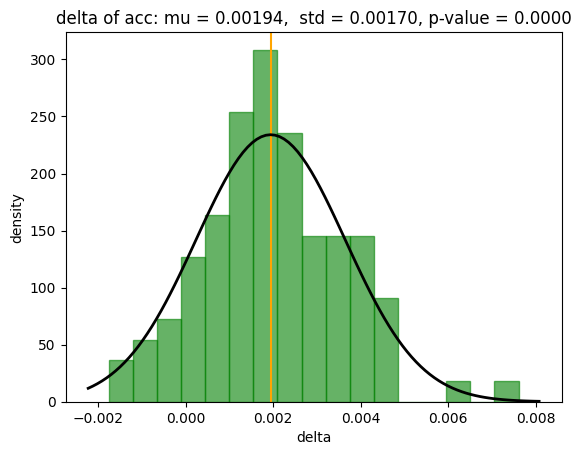

In [ ]:
mu, std = norm.fit(delta_t1)
plt.hist(delta_t1, bins=17, alpha=0.6, density=True, color='g', edgecolor='g')
plt.axvline(sum(delta_t1)/len(delta_t1), color='orange')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
title = "delta of acc: mu = %.5f,  std = %.5f, p-value = %.4f" % (mu, std, p1)
plt.title(title)
plt.plot(x, p, 'k', linewidth=2)
plt.xlabel('delta')
plt.ylabel('density')
plt.savefig('deltat1.png')
plt.show()

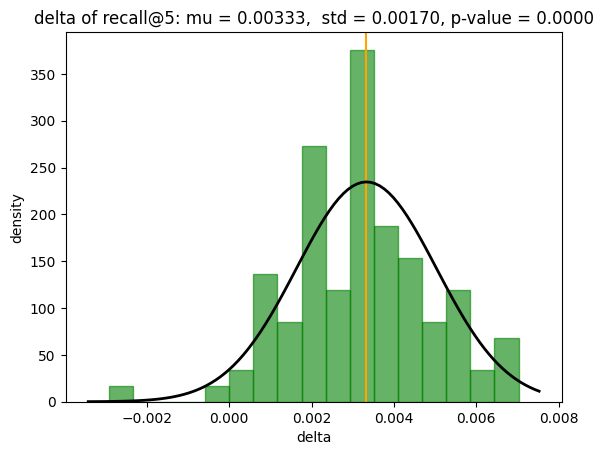

In [ ]:
mu, std = norm.fit(delta_t5)
plt.hist(delta_t5, bins=17, alpha=0.6, density=True, edgecolor='g', color='g')
plt.axvline(sum(delta_t5)/len(delta_t5), color='orange')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
title = "delta of recall@5: mu = %.5f,  std = %.5f, p-value = %.4f" % (mu, std, p5)
plt.title(title)
plt.plot(x, p, 'k', linewidth=2)
plt.xlabel('delta')
plt.ylabel('density')
plt.savefig('deltat5.png')
plt.show()